In [ ]:
!unzip fruits-dataset.zip

Archive:  fruits-dataset.zip
  inflating: annotations/fruit0.xml  
  inflating: annotations/fruit1.xml  
  inflating: annotations/fruit10.xml  
  inflating: annotations/fruit100.xml  
  inflating: annotations/fruit101.xml  
  inflating: annotations/fruit102.xml  
  inflating: annotations/fruit103.xml  
  inflating: annotations/fruit104.xml  
  inflating: annotations/fruit105.xml  
  inflating: annotations/fruit106.xml  
  inflating: annotations/fruit107.xml  
  inflating: annotations/fruit108.xml  
  inflating: annotations/fruit109.xml  
  inflating: annotations/fruit11.xml  
  inflating: annotations/fruit110.xml  
  inflating: annotations/fruit111.xml  
  inflating: annotations/fruit112.xml  
  inflating: annotations/fruit113.xml  
  inflating: annotations/fruit114.xml  
  inflating: annotations/fruit115.xml  
  inflating: annotations/fruit116.xml  
  inflating: annotations/fruit117.xml  
  inflating: annotations/fruit118.xml  
  inflating: annotations/fruit119.xml  
  inflating: anno

In [ ]:
!pip install opencv-contrib-python

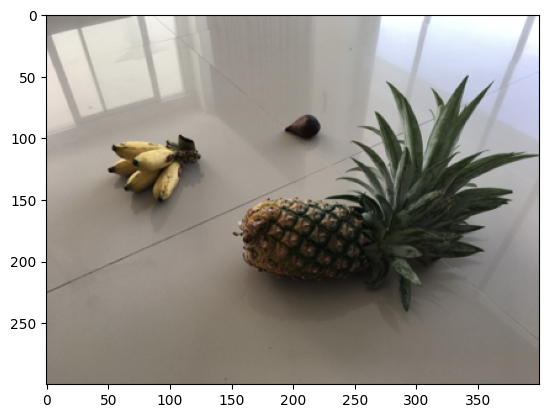

In [ ]:
import os
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt

annot_root = './annotations'
images_root = './images'

img_path = os.path.join(images_root, "fruit135.png")
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

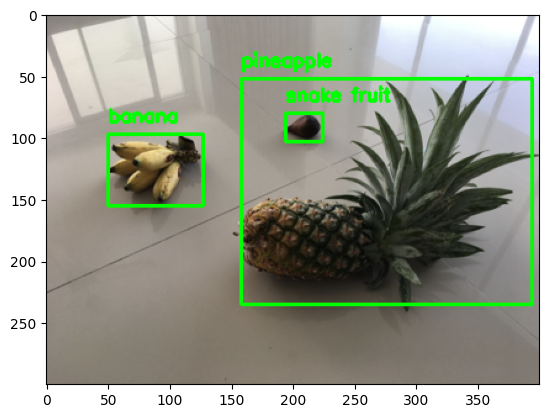

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

# Load the image
img_path = os.path.join(images_root, "fruit135.png")
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Parse the XML annotation file
tree = ET.parse(os.path.join(annot_root, "fruit135.xml"))
root = tree.getroot()

# Iterate through each object in the XML file
for obj in root.findall('object'):
    # Extract object name and bounding box coordinates
    obj_name = obj.find('name').text
    bbox = obj.find('bndbox')
    xmin = int(bbox.find('xmin').text)
    ymin = int(bbox.find('ymin').text)
    xmax = int(bbox.find('xmax').text)
    ymax = int(bbox.find('ymax').text)

    # Draw bounding box on the image
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    cv2.putText(img, obj_name, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the image with bounding boxes
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

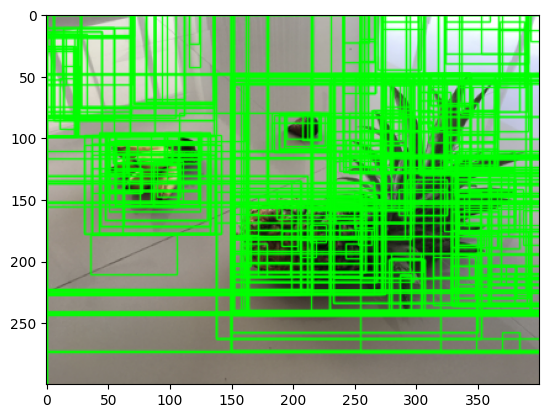

In [ ]:
img_path = os.path.join(images_root, "fruit135.png")

cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
img = cv2.imread(img_path)
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = img.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

img_rgb = cv2.cvtColor(imOut, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

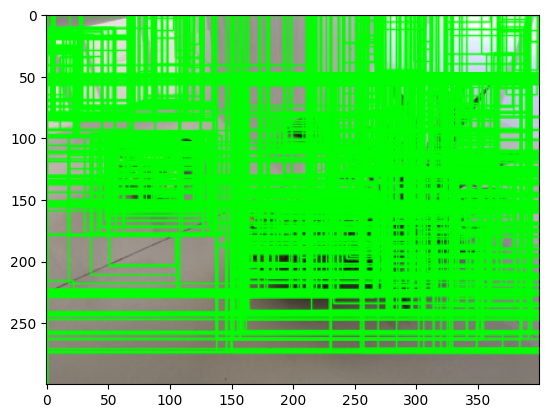

In [ ]:
img_path = os.path.join(images_root, "fruit135.png")

cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
img = cv2.imread(img_path)
ss.setBaseImage(img)
ss.switchToSelectiveSearchQuality()
rects = ss.process()
imOut = img.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

img_rgb = cv2.cvtColor(imOut, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

In [ ]:
# import the necessary packages
import os

ORIG_IMAGES = images_root
ORIG_ANNOTS = annot_root

NUM_CLASSES = 5
CLASSES = ['nothing', 'pineapple', 'snake fruit', 'dragon fruit', 'banana']
COLORS = ['black', 'red', 'green', 'blue', 'yellow']

BASE_PATH = "dataset"
POSITVE_PATH = os.path.sep.join([BASE_PATH, "fruits"])
NEGATIVE_PATH = os.path.sep.join([BASE_PATH, "no_fruits"])

MAX_PROPOSED_ROI = 2000
LIMIT_POS_PROP_ROI = 40
LIMIT_NEG_PROP_ROI = 10

INPUT_DIMS = (224, 224)

MODEL_PATH = "fruit_detector.h5"
ENCODER_PATH = "label_encoder.pickle"

MIN_PROBA = 0.99

MAX_PROP_INFER_ROI = 1000
NMS_THRESHOLD = 0.1

In [ ]:
def compute_iou(box_a, box_b):
    """
      input:
        - box_a: [x_a_min, y_a_min, x_a_max, y_a_max]
        - box_b: [x_b_min, y_b_min, x_b_max, y_b_max]
    """
    x_a_min, y_a_min, x_a_max, y_a_max = box_a
    x_b_min, y_b_min, x_b_max, y_b_max = box_b

    # find (x, y) coordinates of intersection box
    x_inters_min = max(x_a_min, x_b_min)
    y_inters_min = max(y_a_min, y_b_min)
    x_inters_max = min(x_a_max, x_b_max)
    y_inters_max = min(y_a_max, y_b_max)

    # compute area of intersection
    inters_area = max(0, x_inters_max - x_inters_min + 1) * max(0, y_inters_max - y_inters_min + 1) # area = 0 in case 2 boxes don't have any intersection

    # compute area of union = (box_a_area + box_b_area - inters_area)
    union_area = (x_a_max - x_a_min + 1) * (y_a_max - y_a_min + 1) +  (x_b_max - x_b_min + 1) * (y_b_max - y_b_min + 1) - inters_area

    # compute iou = inters_area / union_area
    iou = inters_area / union_area

    return iou

In [ ]:
def overLapped(box_a, box_b):
    """
      input:
        - box_a: [x_a_min, y_a_min, x_a_max, y_a_max]
        - box_b: [x_b_min, y_b_min, x_b_max, y_b_max]
    """
    x_a_min, y_a_min, x_a_max, y_a_max = box_a
    x_b_min, y_b_min, x_b_max, y_b_max = box_b
    # check proposed roi inside totally in ground-truth
    fullOverlap = x_a_min >= x_b_min
    fullOverlap = fullOverlap and y_a_min >= y_b_min
    fullOverlap = fullOverlap and x_a_max <= x_b_max
    fullOverlap = fullOverlap and y_a_max <= y_b_max

    # check ground-truth inside totally in proposed roi
    fullOverlap_2 = x_b_min >= x_a_min
    fullOverlap_2 = fullOverlap_2 and y_b_min >= y_a_min
    fullOverlap_2 = fullOverlap_2 and x_b_max <= x_a_max
    fullOverlap_2 = fullOverlap_2 and y_b_max <= y_a_max

    if fullOverlap == False and not fullOverlap_2 == False:
        return False
    return True

In [ ]:
# import the necessary packages
import numpy as np

def non_max_suppression(boxes, probs=None, overlapThresh=0.1):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []

	# if the bounding boxes are integers, convert them to floats -- this
	# is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")

	# initialize the list of picked indexes
	pick = []

	# grab the coordinates of the bounding boxes
	x1 = boxes[:, 0]
	y1 = boxes[:, 1]
	x2 = boxes[:, 2]
	y2 = boxes[:, 3]

	# compute the area of the bounding boxes and grab the indexes to sort
	# (in the case that no probabilities are provided, simply sort on the
	# bottom-left y-coordinate)
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = y2

	# if probabilities are provided, sort on them instead
	if probs is not None:
		idxs = probs

	# sort the indexes
	idxs = np.argsort(idxs)

	# keep looping while some indexes still remain in the indexes list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the index value
		# to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)

		# find the largest (x, y) coordinates for the start of the bounding
		# box and the smallest (x, y) coordinates for the end of the bounding
		# box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])

		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)

		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]

		# delete all indexes from the index list that have overlap greater
		# than the provided overlap threshold
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))

	# return the indexes of only the bounding boxes to keep
	return pick

In [ ]:
from bs4 import BeautifulSoup
from imutils import paths
import cv2
import os
from tqdm import tqdm
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
image_name_list = os.listdir(ORIG_IMAGES)
annot_name_list = os.listdir(ORIG_ANNOTS)

save_box_path = "./boxes_v2"
save_text_path = open("boxes_v2.txt", 'a')

total_boxes = 0

# loop over the image paths
for i, annot_name in tqdm(enumerate(annot_name_list)):
  # get the full path of xml file
  full_annot_path = os.path.join(ORIG_ANNOTS, annot_name)
  full_img_path = os.path.join(ORIG_IMAGES, image_name_list[i])

  # read the contents of xml file
  contents_xml = open(full_annot_path).read()
  soup = BeautifulSoup(contents_xml, 'html.parser')

  # get the size of image
  img_width = int(soup.find('width').string)
  img_height = int(soup.find('height').string)

  ground_truth_class_indices = []
  ground_truth_boxes = []

  # get class, bounding box of all objects in image
  for obj in soup.find_all('object'):

      # get ground-truth class
      class_name = obj.find('name').string
      class_index = CLASSES.index(class_name)
      ground_truth_class_indices.append(class_index)

      # get ground-truth box
      x_min = int(obj.find('xmin').string)
      x_max = int(obj.find('xmax').string)
      y_min = int(obj.find('ymin').string)
      y_max = int(obj.find('ymax').string)

      # truncate the part of bounding box that fall outsie the size of image
      x_min = max(0, x_min)
      x_max = min(img_width, x_max)
      y_min = max(0, y_min)
      y_max = min(img_height, y_max)

      ground_truth_boxes.append((x_min, y_min, x_max, y_max))

  # read image
  image = cv2.imread(full_img_path)

  # add gtbox as a positive image with a specified class (label)
  for j, gtbox in enumerate(ground_truth_boxes):

      class_index_roi = ground_truth_class_indices[j]

      gt_x_min, gt_y_min, gt_x_max, gt_y_max = gtbox
      gt_roi = image[gt_y_min:gt_y_max, gt_x_min:gt_x_max]

      gt_box_name = f"{total_boxes}.jpg"
      gt_box_path = os.path.join(save_box_path, gt_box_name)
      total_boxes += 1

      # print(class_index_roi)

      # # Display the gt_roi using plt
      # plt.imshow(cv2.cvtColor(gt_roi, cv2.COLOR_BGR2RGB))
      # plt.axis('off')  # Turn off axis labels and ticks
      # plt.show()

      # print(gt_box_path, gt_roi)

      cv2.imwrite(f"{save_box_path}/{gt_box_name}", gt_roi)

      save_text_path.write(f"{class_index_roi} {gt_box_name}\n")

  # run selective search on the image and initialize the list of proposed boxes
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(image)
  ss.switchToSelectiveSearchFast()
  rects = ss.process()
  proposedRects= []

  # loop for each box generated by Selective Search
  for (x_min, y_min, w, h) in rects:
      proposedRects.append((x_min, y_min, x_min + w, y_min + h))

  n_pos = 0
  n_neg = 0

  # loop proposed box
  for propRect in proposedRects[:min(len(proposedRects), MAX_PROPOSED_ROI)]:
      prop_x_min, prop_y_min, prop_x_max, prop_y_max = propRect

      area_propRect = (prop_x_max - prop_x_min + 1) * (prop_y_max - prop_y_min + 1)

      prop_box = None
      prop_box_name = None
      prop_box_path = None
      class_index = None

      chk_neg = False

      # loop for each ground-truth box
      for j, gtbox in enumerate(ground_truth_boxes):
          gt_x_min, gt_y_min, gt_x_max, gt_y_max = gtbox
          class_index_roi = ground_truth_class_indices[j]
          iou = compute_iou(gtbox, propRect)

          # a proposed roi matches A ground-truth => positive
          if iou >= 0.6 and n_pos < LIMIT_POS_PROP_ROI:
              prop_box = image[prop_y_min:prop_y_max, prop_x_min:prop_x_max]

              prop_box_name = f"{total_boxes}.jpg"
              prop_box_path = os.path.join(save_box_path, prop_box_name)

              class_index = class_index_roi
              break

          # check proposed roi inside totally in ground-truth
          fullOverlap = prop_x_min >= gt_x_min
          fullOverlap = fullOverlap and prop_y_min >= gt_y_min
          fullOverlap = fullOverlap and prop_x_max <= gt_x_max
          fullOverlap = fullOverlap and prop_y_max <= gt_y_max

          # check ground-truth inside totally in proposed roi
          fullOverlap_2 = gt_x_min >= prop_x_min
          fullOverlap_2 = fullOverlap_2 and gt_y_min >= prop_y_min
          fullOverlap_2 = fullOverlap_2 and gt_x_max <= prop_x_max
          fullOverlap_2 = fullOverlap_2 and gt_y_max <= prop_y_max

          # a proposed roi doesn't match ALL ground-truth => negative
          if not fullOverlap and not fullOverlap_2 and iou <= 0.05 and n_neg < LIMIT_NEG_PROP_ROI and area_propRect >= 1000:
              chk_neg = True

      if chk_neg:
        prop_box = image[prop_y_min:prop_y_max, prop_x_min:prop_x_max]

        prop_box_name = f"{total_boxes}.jpg"
        prop_box_path = os.path.join(save_box_path, prop_box_name)

        class_index = 0

      if prop_box is not None and prop_box_name is not None and prop_box_path is not None and class_index is not None:
        total_boxes += 1
        cv2.imwrite(prop_box_path, prop_box)
        save_text_path.write(f"{class_index} {prop_box_name}\n")
        if class_index == 0:
            n_neg += 1
        else:
            n_pos += 1

save_text_path.close()

In [ ]:
!unzip boxes_v3.zip

Streaming output truncated to the last 5000 lines.
  inflating: boxes_v3/5379.jpg       
  inflating: boxes_v3/538.jpg        
  inflating: boxes_v3/5380.jpg       
  inflating: boxes_v3/5381.jpg       
  inflating: boxes_v3/5382.jpg       
  inflating: boxes_v3/5383.jpg       
  inflating: boxes_v3/5384.jpg       
  inflating: boxes_v3/5385.jpg       
  inflating: boxes_v3/5386.jpg       
  inflating: boxes_v3/5387.jpg       
  inflating: boxes_v3/5388.jpg       
  inflating: boxes_v3/5389.jpg       
  inflating: boxes_v3/539.jpg        
  inflating: boxes_v3/5390.jpg       
  inflating: boxes_v3/5391.jpg       
  inflating: boxes_v3/5392.jpg       
  inflating: boxes_v3/5393.jpg       
  inflating: boxes_v3/5394.jpg       
  inflating: boxes_v3/5395.jpg       
  inflating: boxes_v3/5396.jpg       
  inflating: boxes_v3/5397.jpg       
  inflating: boxes_v3/5398.jpg       
  inflating: boxes_v3/5399.jpg       
  inflating: boxes_v3/54.jpg         
  inflating: boxes_v3/540.jpg        

In [ ]:
data_folder="boxes_v3"
dataset_file="boxes_v3.txt"

f = open(dataset_file, 'r')
class_index_list = []
image_path_list = []

for line in f.readlines():
    class_index, file_name = [x.strip() for x in line.split(" ")]
    image_path = os.path.join(data_folder, file_name)
    class_index_list.append(int(class_index))
    image_path_list.append(image_path)
f.close()

images = []
labels = []

for index in range(len(image_path_list)):
    label = class_index_list[index]
    image_path = image_path_list[index]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (384, 384))

    images.append(image)
    labels.append(label)

images_array = np.array(images)
labels_array = np.array(labels)

In [ ]:
data_folder = "boxes_v3"
dataset_file = "boxes_v3.txt"

def data_generator():
    with open(dataset_file, 'r') as f:
        lines = f.readlines()
        np.random.shuffle(lines)
        for line in lines:
            class_index, file_name = [x.strip() for x in line.split(" ")]
            image_path = os.path.join(data_folder, file_name)
            label = int(class_index)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            yield image, label

samples_per_class = 333
class_samples = {}
images, labels = [], []

for image, label in data_generator():
    if label not in class_samples:
        class_samples[label] = 0

    if class_samples[label] < samples_per_class:
        images.append(image)
        labels.append(label)
        class_samples[label] += 1

images_array = np.array(images)
labels_array = np.array(labels)

In [ ]:
images_array.shape

(1665, 224, 224, 3)

In [ ]:
labels_array.shape

(1665,)

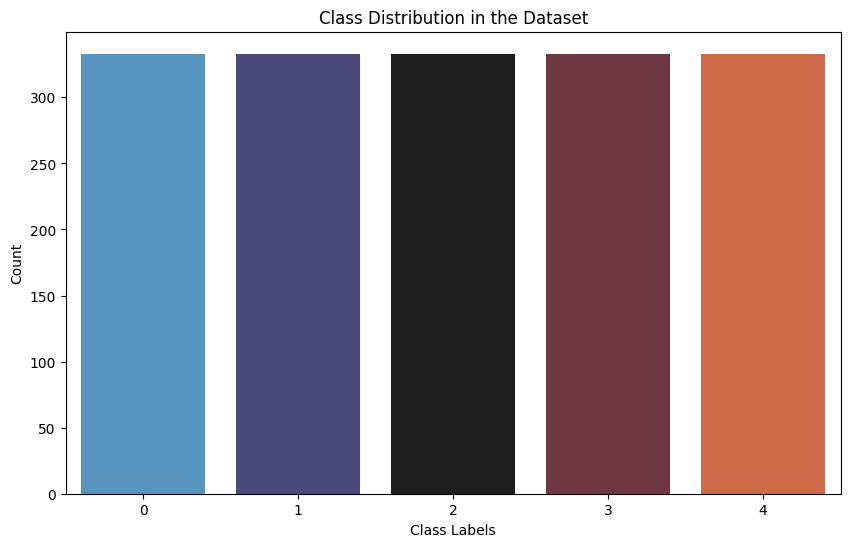

In [ ]:
import seaborn as sns

class_counts = np.bincount(labels_array)

unique_classes = np.arange(len(class_counts))

plt.figure(figsize=(10, 6))
sns.barplot(x=unique_classes, y=class_counts, palette="icefire")
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.title("Class Distribution in the Dataset")
plt.show()

In [ ]:
from keras.utils import to_categorical

y_one_hot = to_categorical(labels_array)

print(y_one_hot[0], labels_array[0])

[0. 1. 0. 0. 0.] 1


In [ ]:
images_array = images_array / 255

In [ ]:
from sklearn.model_selection import train_test_split

(trainX, testX, trainY, testY) = train_test_split(images_array, y_one_hot, test_size=0.20, stratify=y_one_hot, random_state=42)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model
from keras.applications.mobilenet_v2 import preprocess_input
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np

aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.1,
	width_shift_range=0.1,
	height_shift_range=0.1,
	horizontal_flip=True,
  vertical_flip=True,
	fill_mode="nearest"
)

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(5, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
BS = 32

history = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=10
)

Epoch 1/10
41/41 [==============================] - 86s 2s/step - loss: 0.2254 - accuracy: 0.8100 - val_loss: 0.0783 - val_accuracy: 0.9489
Epoch 2/10
41/41 [==============================] - 91s 2s/step - loss: 0.1033 - accuracy: 0.9523 - val_loss: 0.0589 - val_accuracy: 0.9640
Epoch 3/10
41/41 [==============================] - 83s 2s/step - loss: 0.0918 - accuracy: 0.9469 - val_loss: 0.0458 - val_accuracy: 0.9670
Epoch 4/10
41/41 [==============================] - 78s 2s/step - loss: 0.0736 - accuracy: 0.9569 - val_loss: 0.0522 - val_accuracy: 0.9670
Epoch 5/10
41/41 [==============================] - 84s 2s/step - loss: 0.0642 - accuracy: 0.9631 - val_loss: 0.0508 - val_accuracy: 0.9670
Epoch 6/10
41/41 [==============================] - 84s 2s/step - loss: 0.0597 - accuracy: 0.9662 - val_loss: 0.0387 - val_accuracy: 0.9760
Epoch 7/10
41/41 [==============================] - 83s 2s/step - loss: 0.0597 - accuracy: 0.9669 - val_loss: 0.0452 - val_accuracy: 0.9700
Epoch 8/10
41/41 [==

In [ ]:
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=['nothing', 'pineapple', 'snake fruit', 'dragon fruit', 'banana']))

11/11 [==============================] - 18s 2s/step
              precision    recall  f1-score   support

     nothing       1.00      0.85      0.92        66
   pineapple       0.99      1.00      0.99        67
 snake fruit       1.00      1.00      1.00        67
dragon fruit       0.99      1.00      0.99        66
      banana       0.89      1.00      0.94        67

    accuracy                           0.97       333
   macro avg       0.97      0.97      0.97       333
weighted avg       0.97      0.97      0.97       333



In [ ]:
def plot_loss_and_accuracy(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].plot(history.history['loss'], label='train loss')
    axes[0].plot(history.history['val_loss'], label='val loss')
    axes[0].set_title('Losses')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(history.history['accuracy'], label='train accuracy')
    axes[1].plot(history.history['val_accuracy'], label='val accuracy')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

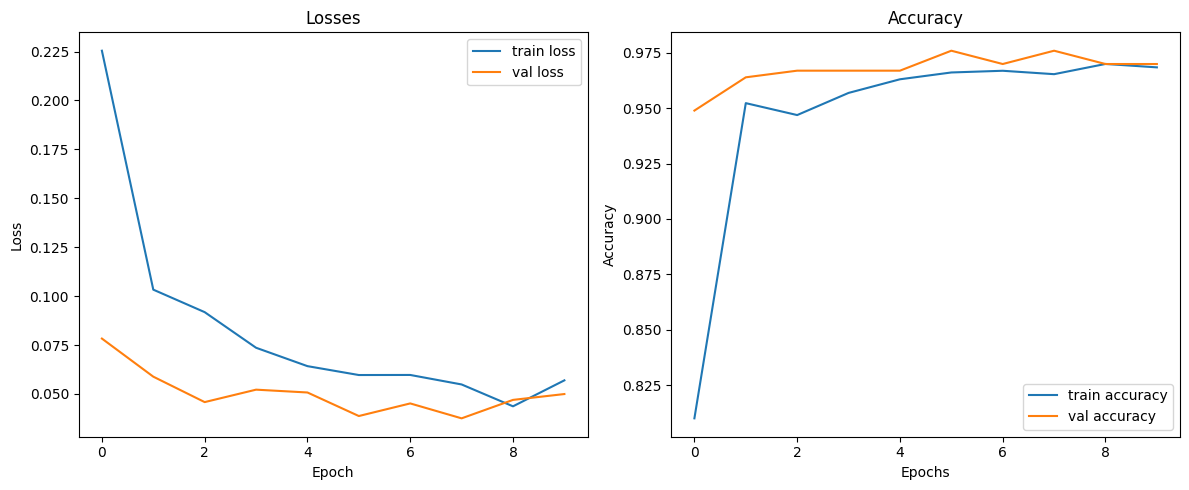

In [ ]:
plot_loss_and_accuracy(history)

[INFO] proposal shape: (200, 224, 224, 3)
[INFO] classifying proposals...
7/7 [==============================] - 8s 1s/step


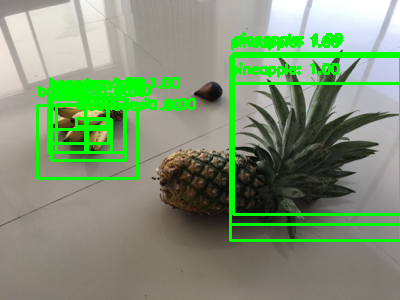

In [ ]:
# from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing.image import img_to_array
from google.colab.patches import cv2_imshow
import numpy as np
import os

img_path = os.path.join('./images', "fruit135.png")
# img = image.load_img(os.path.join('./boxes_v3', "1038.jpg"), target_size=(224, 224))
# img = image.load_img(img_path, target_size=(224, 224))
# img = image.img_to_array(img)
# img = np.expand_dims(img, axis=0)
# img = preprocess_input(img)

img = cv2.imread(img_path)


ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process()

proposals = []
boxes = []

for (x, y, w, h) in rects[:200]:
	# extract the region from the input image, convert it from BGR to
	# RGB channel ordering, and then resize it to the required input
	# dimensions of our trained CNN
	roi = img[y:y + h, x:x + w]
	roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
	roi = cv2.resize(roi, (224, 224), interpolation=cv2.INTER_CUBIC)

	# further preprocess by the ROI
	roi = img_to_array(roi)
	roi = preprocess_input(roi)

	# update our proposals and bounding boxes lists
	proposals.append(roi)
	boxes.append((x, y, x + w, y + h))


# convert the proposals and bounding boxes into NumPy arrays
proposals = np.array(proposals, dtype="float32")
boxes = np.array(boxes, dtype="int32")
print("[INFO] proposal shape: {}".format(proposals.shape))

# classify each of the proposal ROIs using fine-tuned model
print("[INFO] classifying proposals...")
proba = model.predict(proposals)

# clone the original image so that we can draw on it
clone = img.copy()

# loop over the bounding boxes and associated probabilities
for (box, prob) in zip(boxes, proba):
	# draw the bounding box, label, and probability on the image
	(startX, startY, endX, endY) = box

	class_idx = np.argmax(prob)
	confidence = prob[class_idx]
	label = f"{CLASSES[class_idx]}: {confidence:.2f}"
	if class_idx != 0 and confidence >= 0.999:
		cv2.rectangle(clone, (startX, startY), (endX, endY), (0, 255, 0), 2)
		y = startY - 10 if startY - 10 > 10 else startY + 10

		cv2.putText(clone, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)


# show the output after *before* running NMS
cv2_imshow(clone)

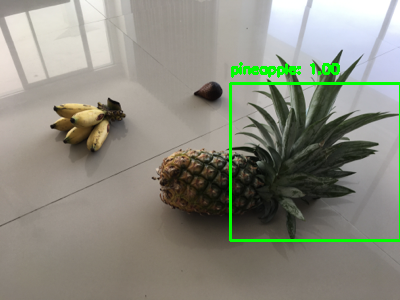

In [ ]:
confidences = proba[:, 1]  # Assuming the first class is the background

nms_boxes = cv2.dnn.NMSBoxes(boxes, confidences, 0.9, 0.1)

# Clone the original image to draw on
clone = img.copy()

# Loop over the bounding boxes that survived NMS
for i in nms_boxes:
    box = boxes[i]  # Get the box based on the index
    prob = proba[i]  # Get the probability based on the index

    # Draw the bounding box, label, and probability on the image
    (startX, startY, endX, endY) = box

    class_idx = np.argmax(prob)
    confidence = prob[class_idx]
    label = f"{CLASSES[class_idx]}: {confidence:.2f}"

    cv2.rectangle(clone, (startX, startY), (endX, endY), (0, 255, 0), 2)
    y = startY - 10 if startY - 10 > 10 else startY + 10

    cv2.putText(clone, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

# Show the output after running NMS
cv2_imshow(clone)